In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, KFold
import xgboost as xgb
from scripts.function_utils import correct_wind_direction, plot_results, performance_metrics, build_model, past_timesteps, add_energy_variation

In [2]:
df = pd.read_csv("../../data/porto.csv", decimal=",", index_col=[0])
df.Time = pd.to_datetime(df.Time)
df

,Time,Energy,Location
0,2019-01-01 00:00:00,2.964000,0
1,2019-01-01 00:15:00,2.584000,0
2,2019-01-01 00:30:00,3.071000,0
3,2019-01-01 00:45:00,2.694000,0
4,2019-01-01 01:00:00,2.569000,0
...,...,...,...
1791931,2020-01-01 22:45:00,0.753222,50
1791932,2020-01-01 23:00:00,0.716855,50
1791933,2020-01-01 23:15:00,0.735802,50
1791934,2020-01-01 23:30:00,0.485237,50


In [3]:
df.isnull().sum()

Time        0
Energy      0
Location    0
dtype: int64

### First Model (last hour)

In [4]:
n_timesteps = 4
past = past_timesteps(df, n_timesteps)
X1, y1 = past.drop(["Time", "Location", "Energy"], axis=1), past.Energy
X1

 50%|█████     | 2/4 [00:00<00:00, 18.01it/s]

100%|██████████| 4/4 [00:00<00:00, 23.73it/s]


,lag_1,lag_2,lag_3,lag_4
0,2.694000,3.071000,2.584000,2.964000
1,2.569000,2.694000,3.071000,2.584000
2,3.174000,2.569000,2.694000,3.071000
3,2.558000,3.174000,2.569000,2.694000
4,2.922000,2.558000,3.174000,2.569000
...,...,...,...,...
1791727,1.099100,0.453906,0.481770,0.483173
1791728,0.753222,1.099100,0.453906,0.481770
1791729,0.716855,0.753222,1.099100,0.453906
1791730,0.735802,0.716855,0.753222,1.099100


In [5]:
pd.DataFrame(y1)

,Energy
0,2.569000
1,3.174000
2,2.558000
3,2.922000
4,2.994000
...,...
1791727,0.753222
1791728,0.716855
1791729,0.735802
1791730,0.485237


### Second Model (last 24 hours)
##### Since the data is in intervals of 15 minutes, it will add 24 * 4 = 96 new features

In [6]:
n_timesteps = 96
past = past_timesteps(df, n_timesteps)
X2, y2 = past.drop(["Time", "Location", "Energy"], axis=1), past.Energy
X2

100%|██████████| 96/96 [00:02<00:00, 32.43it/s]


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96
0,2.528000,2.917000,2.483000,2.575000,3.039000,3.288000,2.629000,2.599000,2.344000,2.377000,...,3.223000,2.994000,2.922000,2.558000,3.174000,2.569000,2.694000,3.071000,2.584000,2.964000
1,3.054000,2.528000,2.917000,2.483000,2.575000,3.039000,3.288000,2.629000,2.599000,2.344000,...,2.553000,3.223000,2.994000,2.922000,2.558000,3.174000,2.569000,2.694000,3.071000,2.584000
2,2.677000,3.054000,2.528000,2.917000,2.483000,2.575000,3.039000,3.288000,2.629000,2.599000,...,3.047000,2.553000,3.223000,2.994000,2.922000,2.558000,3.174000,2.569000,2.694000,3.071000
3,3.522000,2.677000,3.054000,2.528000,2.917000,2.483000,2.575000,3.039000,3.288000,2.629000,...,3.310000,3.047000,2.553000,3.223000,2.994000,2.922000,2.558000,3.174000,2.569000,2.694000
4,2.729000,3.522000,2.677000,3.054000,2.528000,2.917000,2.483000,2.575000,3.039000,3.288000,...,2.514000,3.310000,3.047000,2.553000,3.223000,2.994000,2.922000,2.558000,3.174000,2.569000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787035,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,0.533451,0.464143,...,1.014065,1.021784,1.082588,0.858855,0.881889,1.077717,0.715781,0.935428,0.752850,0.641933
1787036,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,0.533451,...,1.026614,1.014065,1.021784,1.082588,0.858855,0.881889,1.077717,0.715781,0.935428,0.752850
1787037,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,...,0.848700,1.026614,1.014065,1.021784,1.082588,0.858855,0.881889,1.077717,0.715781,0.935428
1787038,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,...,1.156395,0.848700,1.026614,1.014065,1.021784,1.082588,0.858855,0.881889,1.077717,0.715781


In [7]:
pd.DataFrame(y2)

,Energy
0,3.054000
1,2.677000
2,3.522000
3,2.729000
4,2.368000
...,...
1787035,0.753222
1787036,0.716855
1787037,0.735802
1787038,0.485237


### Third Model (last 7 days at exact same time)
##### Multiply i by 96 to skip a day

In [8]:
features_7 = df.sort_values(by=['Location', 'Time'])
for i in range(1, 8):
    features_7.loc[features_7['Time'].shift(i*96) == features_7['Time'] - pd.Timedelta(i, 'day'), f"lag_{i*96}"] = features_7['Energy'].shift(i*96)
features_7.dropna(inplace=True)
features_7.reset_index(drop=True, inplace=True)
features_7

,Time,Energy,Location,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672
0,2019-01-08 00:00:00,4.940000,0,2.615000,3.321000,3.066000,2.351000,2.851000,3.054000,2.964000
1,2019-01-08 00:15:00,4.149000,0,2.634000,2.873000,3.152000,2.843000,3.102000,2.677000,2.584000
2,2019-01-08 00:30:00,4.401000,0,3.052000,3.407000,2.633000,2.949000,2.546000,3.522000,3.071000
3,2019-01-08 00:45:00,4.431000,0,2.893000,2.673000,2.590000,2.605000,3.016000,2.729000,2.694000
4,2019-01-08 01:00:00,3.988000,0,2.349000,2.390000,2.330000,3.023000,3.031000,2.368000,2.569000
...,...,...,...,...,...,...,...,...,...,...
1757659,2020-01-01 22:45:00,0.753222,50,0.641933,0.778195,0.753222,0.641933,0.778195,0.753222,1.723943
1757660,2020-01-01 23:00:00,0.716855,50,0.752850,0.931837,0.716855,0.752850,0.931837,0.716855,1.482914
1757661,2020-01-01 23:15:00,0.735802,50,0.935428,0.937079,0.735802,0.935428,0.937079,0.735802,1.772033
1757662,2020-01-01 23:30:00,0.485237,50,0.715781,0.803087,0.485237,0.715781,0.803087,0.485237,2.535657


In [9]:
X3, y3 = features_7.drop(["Time", "Location", "Energy"], axis=1), features_7.Energy
X3

,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672
0,2.615000,3.321000,3.066000,2.351000,2.851000,3.054000,2.964000
1,2.634000,2.873000,3.152000,2.843000,3.102000,2.677000,2.584000
2,3.052000,3.407000,2.633000,2.949000,2.546000,3.522000,3.071000
3,2.893000,2.673000,2.590000,2.605000,3.016000,2.729000,2.694000
4,2.349000,2.390000,2.330000,3.023000,3.031000,2.368000,2.569000
...,...,...,...,...,...,...,...
1757659,0.641933,0.778195,0.753222,0.641933,0.778195,0.753222,1.723943
1757660,0.752850,0.931837,0.716855,0.752850,0.931837,0.716855,1.482914
1757661,0.935428,0.937079,0.735802,0.935428,0.937079,0.735802,1.772033
1757662,0.715781,0.803087,0.485237,0.715781,0.803087,0.485237,2.535657


In [10]:
pd.DataFrame(y3)

,Energy
0,4.940000
1,4.149000
2,4.401000
3,4.431000
4,3.988000
...,...
1757659,0.753222
1757660,0.716855
1757661,0.735802
1757662,0.485237


### Fourth Model (last hour + last 7 days at exact same time + DayOfWeek + Hour)

In [11]:
features_7 = df.sort_values(by=['Location', 'Time'])
for i in range(1, 5):
    features_7.loc[features_7['Time'].shift(i) == features_7['Time'] - pd.Timedelta(i*15, 'm'), f"lag_{i}"] = features_7['Energy'].shift(i)
for i in range(1, 8):
    features_7.loc[features_7['Time'].shift(i*96) == features_7['Time'] - pd.Timedelta(i, 'day'), f"lag_{i*96}"] = features_7['Energy'].shift(i*96)
features_7.dropna(inplace=True)
features_7.reset_index(drop=True, inplace=True)
features_7

,Time,Energy,Location,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672
0,2019-01-08 00:00:00,4.940000,0,3.952000,3.803000,4.095000,3.926000,2.615000,3.321000,3.066000,2.351000,2.851000,3.054000,2.964000
1,2019-01-08 00:15:00,4.149000,0,4.940000,3.952000,3.803000,4.095000,2.634000,2.873000,3.152000,2.843000,3.102000,2.677000,2.584000
2,2019-01-08 00:30:00,4.401000,0,4.149000,4.940000,3.952000,3.803000,3.052000,3.407000,2.633000,2.949000,2.546000,3.522000,3.071000
3,2019-01-08 00:45:00,4.431000,0,4.401000,4.149000,4.940000,3.952000,2.893000,2.673000,2.590000,2.605000,3.016000,2.729000,2.694000
4,2019-01-08 01:00:00,3.988000,0,4.431000,4.401000,4.149000,4.940000,2.349000,2.390000,2.330000,3.023000,3.031000,2.368000,2.569000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757659,2020-01-01 22:45:00,0.753222,50,1.099100,0.453906,0.481770,0.483173,0.641933,0.778195,0.753222,0.641933,0.778195,0.753222,1.723943
1757660,2020-01-01 23:00:00,0.716855,50,0.753222,1.099100,0.453906,0.481770,0.752850,0.931837,0.716855,0.752850,0.931837,0.716855,1.482914
1757661,2020-01-01 23:15:00,0.735802,50,0.716855,0.753222,1.099100,0.453906,0.935428,0.937079,0.735802,0.935428,0.937079,0.735802,1.772033
1757662,2020-01-01 23:30:00,0.485237,50,0.735802,0.716855,0.753222,1.099100,0.715781,0.803087,0.485237,0.715781,0.803087,0.485237,2.535657


In [12]:
X4 = features_7
X4["DayOfWeek"] = features_7.Time.dt.dayofweek
X4["Hour"] = features_7.Time.dt.hour
X4.drop(["Time", "Location", "Energy"], axis=1, inplace=True)
y4 = y3
X4

,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour
0,3.952000,3.803000,4.095000,3.926000,2.615000,3.321000,3.066000,2.351000,2.851000,3.054000,2.964000,1,0
1,4.940000,3.952000,3.803000,4.095000,2.634000,2.873000,3.152000,2.843000,3.102000,2.677000,2.584000,1,0
2,4.149000,4.940000,3.952000,3.803000,3.052000,3.407000,2.633000,2.949000,2.546000,3.522000,3.071000,1,0
3,4.401000,4.149000,4.940000,3.952000,2.893000,2.673000,2.590000,2.605000,3.016000,2.729000,2.694000,1,0
4,4.431000,4.401000,4.149000,4.940000,2.349000,2.390000,2.330000,3.023000,3.031000,2.368000,2.569000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757659,1.099100,0.453906,0.481770,0.483173,0.641933,0.778195,0.753222,0.641933,0.778195,0.753222,1.723943,2,22
1757660,0.753222,1.099100,0.453906,0.481770,0.752850,0.931837,0.716855,0.752850,0.931837,0.716855,1.482914,2,23
1757661,0.716855,0.753222,1.099100,0.453906,0.935428,0.937079,0.735802,0.935428,0.937079,0.735802,1.772033,2,23
1757662,0.735802,0.716855,0.753222,1.099100,0.715781,0.803087,0.485237,0.715781,0.803087,0.485237,2.535657,2,23


In [13]:
pd.DataFrame(y4)

,Energy
0,4.940000
1,4.149000
2,4.401000
3,4.431000
4,3.988000
...,...
1757659,0.753222
1757660,0.716855
1757661,0.735802
1757662,0.485237


### Fifth Model (last hour + DayOfWeek + Hour + Variation)

In [14]:
n_timesteps = 4
past_5th = past_timesteps(df, n_timesteps)
vari = add_energy_variation(past_5th)
X5 = past_5th.copy()
X5.drop(["Time", "Location", "Energy"], axis=1, inplace=True)
X5["DayOfWeek"] = past_5th.Time.dt.dayofweek
X5["Hour"] = past_5th.Time.dt.hour
y5 = past_5th.Energy
X5

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 25.89it/s]


,lag_1,lag_2,lag_3,lag_4,Variation,DayOfWeek,Hour
0,2.694000,3.071000,2.584000,2.964000,0.000000,1,1
1,2.569000,2.694000,3.071000,2.584000,0.000000,1,1
2,3.174000,2.569000,2.694000,3.071000,0.235495,1,1
3,2.558000,3.174000,2.569000,2.694000,-0.194079,1,1
4,2.922000,2.558000,3.174000,2.569000,0.142294,1,2
...,...,...,...,...,...,...,...
1791727,1.099100,0.453906,0.481770,0.483173,1.421373,2,22
1791728,0.753222,1.099100,0.453906,0.481770,-0.314699,2,23
1791729,0.716855,0.753222,1.099100,0.453906,-0.048295,2,23
1791730,0.735802,0.716855,0.753222,1.099100,0.026417,2,23


In [15]:
pd.DataFrame(y5)

,Energy
0,2.569000
1,3.174000
2,2.558000
3,2.922000
4,2.994000
...,...
1791727,0.753222
1791728,0.716855
1791729,0.735802
1791730,0.485237


### Sixth Model (last hour + last 7 days + DayOfWeek + Hour + Variation)

In [16]:
tmp = add_energy_variation(pd.DataFrame(y4))
X6 = X4.copy()
X6["Variation"] = tmp["Variation"]
y6 = y4.copy()
X6

,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Variation
0,3.952000,3.803000,4.095000,3.926000,2.615000,3.321000,3.066000,2.351000,2.851000,3.054000,2.964000,1,0,0.000000
1,4.940000,3.952000,3.803000,4.095000,2.634000,2.873000,3.152000,2.843000,3.102000,2.677000,2.584000,1,0,0.000000
2,4.149000,4.940000,3.952000,3.803000,3.052000,3.407000,2.633000,2.949000,2.546000,3.522000,3.071000,1,0,-0.160123
3,4.401000,4.149000,4.940000,3.952000,2.893000,2.673000,2.590000,2.605000,3.016000,2.729000,2.694000,1,0,0.060735
4,4.431000,4.401000,4.149000,4.940000,2.349000,2.390000,2.330000,3.023000,3.031000,2.368000,2.569000,1,1,0.006814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757659,1.099100,0.453906,0.481770,0.483173,0.641933,0.778195,0.753222,0.641933,0.778195,0.753222,1.723943,2,22,1.421373
1757660,0.753222,1.099100,0.453906,0.481770,0.752850,0.931837,0.716855,0.752850,0.931837,0.716855,1.482914,2,23,-0.314699
1757661,0.716855,0.753222,1.099100,0.453906,0.935428,0.937079,0.735802,0.935428,0.937079,0.735802,1.772033,2,23,-0.048295
1757662,0.735802,0.716855,0.753222,1.099100,0.715781,0.803087,0.485237,0.715781,0.803087,0.485237,2.535657,2,23,0.026417


In [17]:
pd.DataFrame(y6)

,Energy
0,4.940000
1,4.149000
2,4.401000
3,4.431000
4,3.988000
...,...
1757659,0.753222
1757660,0.716855
1757661,0.735802
1757662,0.485237


## Train and Predict Models

In [18]:
# First Model (all weather features)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
model1, preds1 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X1_train, y1_train, X1_test)

# Second Model (weather features + last 24 hours)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
model2, preds2 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X2_train, y2_train, X2_test)

# Third Model (weather features + last 7 days at the exact same time)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
model3, preds3 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X3_train, y3_train, X3_test)

# Fourth Model (last hour + last 7 days at exact same time + DayOfWeek + Hour))
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)
model4, preds4 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X4_train, y4_train, X4_test)

# Fifth Model (last hour + DayOfWeek + Hour + Variation)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42)
model5, preds5 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X5_train, y5_train, X5_test)

# Sixth Model (last hour + last 7 days + DayOfWeek + Hour + Variation)
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size=0.2, random_state=42)
model6, preds6 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X6_train, y6_train, X6_test)

## Plot Models and Show Performance Metrics

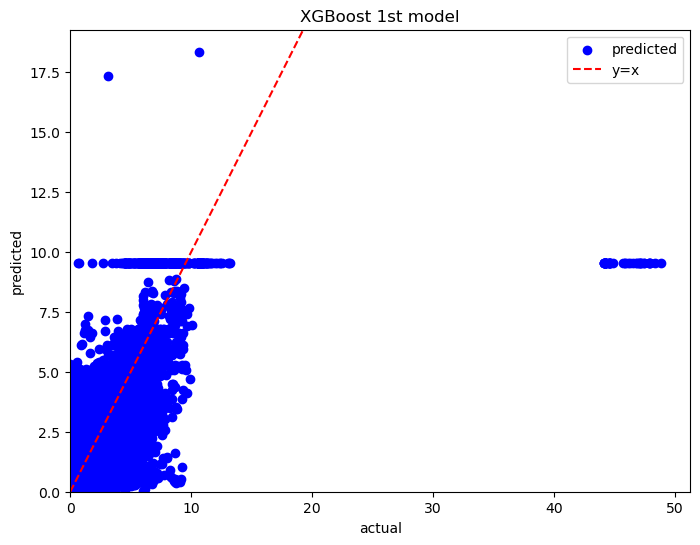

In [19]:
plt.figure(figsize=(8, 6))

plot_results(preds1, y1_test, 'XGBoost 1st model')

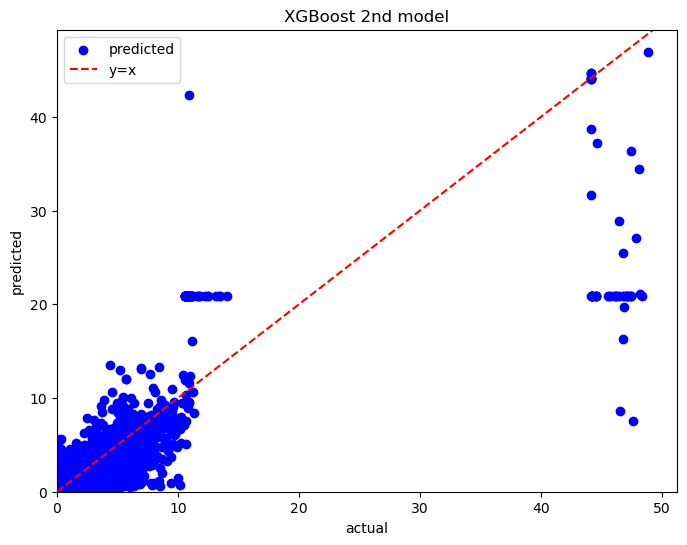

In [20]:
plt.figure(figsize=(8, 6))

plot_results(preds2, y2_test, 'XGBoost 2nd model')

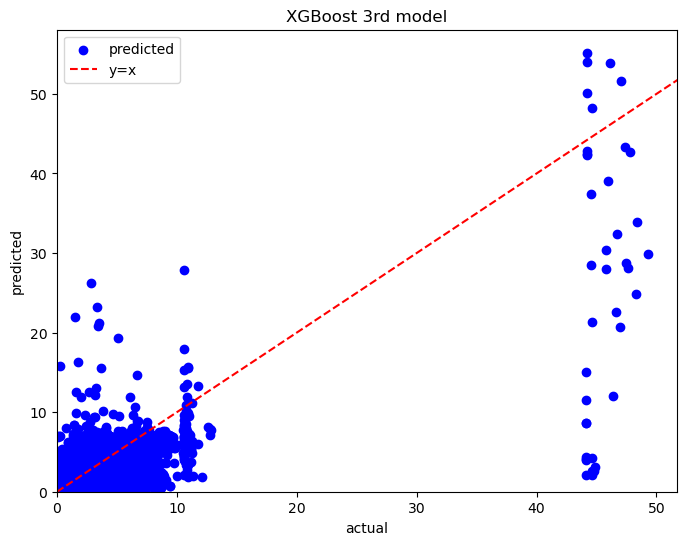

In [21]:
plt.figure(figsize=(8, 6))

plot_results(preds3, y3_test, 'XGBoost 3rd model')

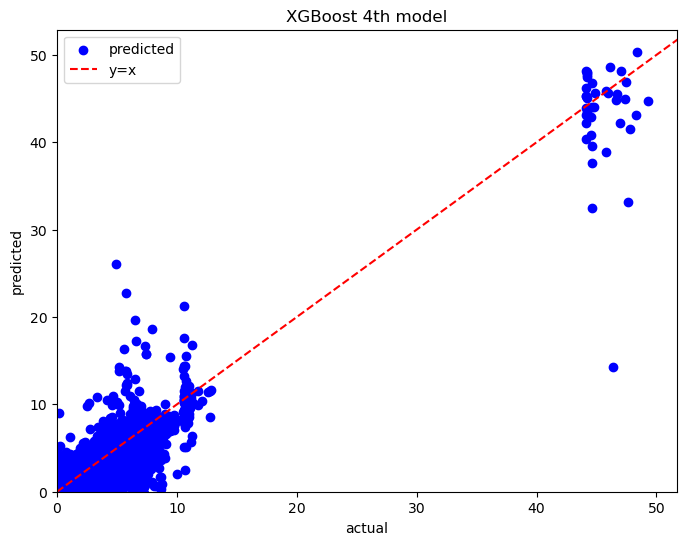

In [22]:
plt.figure(figsize=(8, 6))

plot_results(preds4, y4_test, 'XGBoost 4th model')

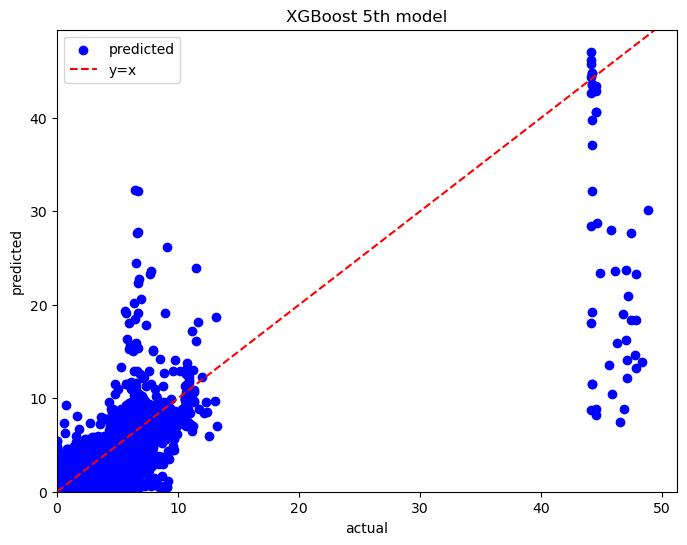

In [23]:
plt.figure(figsize=(8, 6))

plot_results(preds5, y5_test, 'XGBoost 5th model')

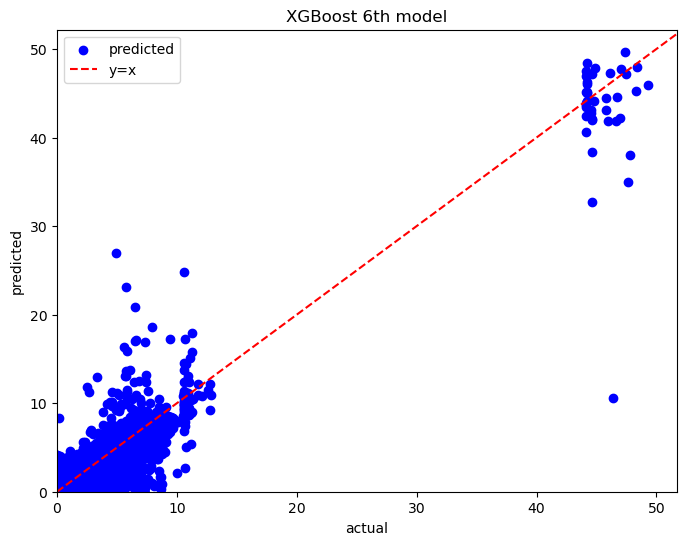

In [24]:
plt.figure(figsize=(8, 6))

plot_results(preds6, y6_test, 'XGBoost 6th model')

In [25]:
print("First Model")
performance_metrics(preds1, y1_test.values.reshape(-1))
print()
print("Second Model")
performance_metrics(preds2, y2_test.values.reshape(-1))
print()
print("Third Model")
performance_metrics(preds3, y3_test.values.reshape(-1))

First Model
MSE: 0.3718
RMSE: 0.6098
WAPE: 29.32
R2: 0.6899

Second Model
MSE: 0.2383
RMSE: 0.4881
WAPE: 27.09
R2: 0.8059

Third Model
MSE: 0.4684
RMSE: 0.6844
WAPE: 49.00
R2: 0.5950


(0.4684, 49.0, 0.595)

In [26]:
print("Fourth Model")
performance_metrics(preds4, y4_test.values.reshape(-1))
print()
print("Fifth Model")
performance_metrics(preds5, y5_test.values.reshape(-1))
print()
print("Sixth Model")
performance_metrics(preds6, y6_test.values.reshape(-1))

Fourth Model
MSE: 0.1718
RMSE: 0.4146
WAPE: 27.52
R2: 0.8514

Fifth Model
MSE: 0.2741
RMSE: 0.5235
WAPE: 28.40
R2: 0.7714

Sixth Model
MSE: 0.1671
RMSE: 0.4088
WAPE: 26.85
R2: 0.8555


(0.1671, 26.85, 0.8555)

## Cross Validation

In [27]:
def cv_validate(classifier, X, y, k):
    scores = cross_validate(classifier, X, y, cv=KFold(n_splits=k, shuffle=True),scoring='r2', return_estimator=True)
    print("R2 score: %0.2f +- %0.2f" % (scores['test_score'].mean(), scores['test_score'].std()))
    return scores

In [28]:
scores1 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X1_train, y1_train, 5)

R2 score: 0.70 +- 0.01


In [29]:
scores2 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X2_train, y2_train, 5)

R2 score: 0.81 +- 0.01


In [30]:
scores3 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X3_train, y3_train, 5)

R2 score: 0.58 +- 0.02


In [31]:
scores4 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X4_train, y4_train, 5)

R2 score: 0.85 +- 0.00


In [32]:
scores5 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X5_train, y5_train, 5)

R2 score: 0.78 +- 0.01


In [33]:
scores6 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X6_train, y6_train, 5)

R2 score: 0.86 +- 0.01


In [34]:
scores1['test_score'], scores2['test_score'], scores3['test_score'], scores4['test_score'], scores5['test_score'], scores6['test_score']

(array([0.71490136, 0.69101822, 0.70872177, 0.69042315, 0.70201506]),
 array([0.81137605, 0.8207831 , 0.81763349, 0.79933244, 0.8165086 ]),
 array([0.5879029 , 0.59711763, 0.54541408, 0.58720625, 0.5779267 ]),
 array([0.85114374, 0.84802141, 0.85518239, 0.85508469, 0.8454284 ]),
 array([0.79507038, 0.79232092, 0.76939189, 0.77957166, 0.77439334]),
 array([0.85647365, 0.8473989 , 0.86237609, 0.86178079, 0.8537007 ]))

## Feature Importance

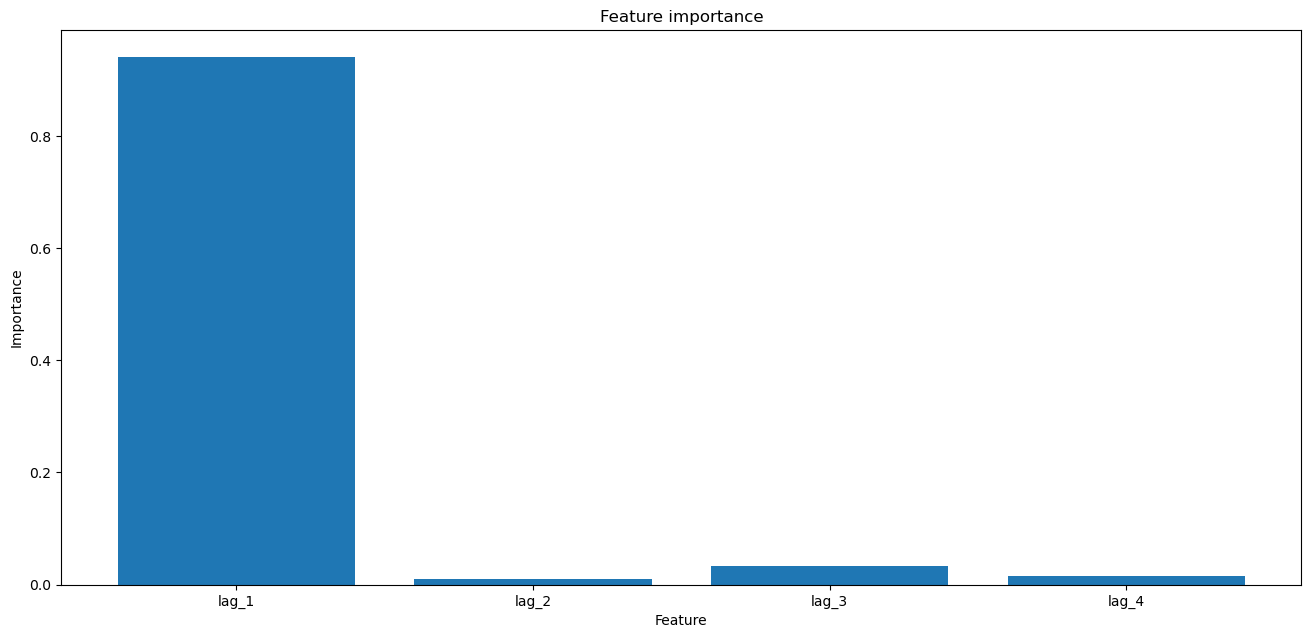

In [35]:
time_importance = model1.feature_importances_

plt.figure(figsize=(16, 7.2))
plt.bar(X1.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

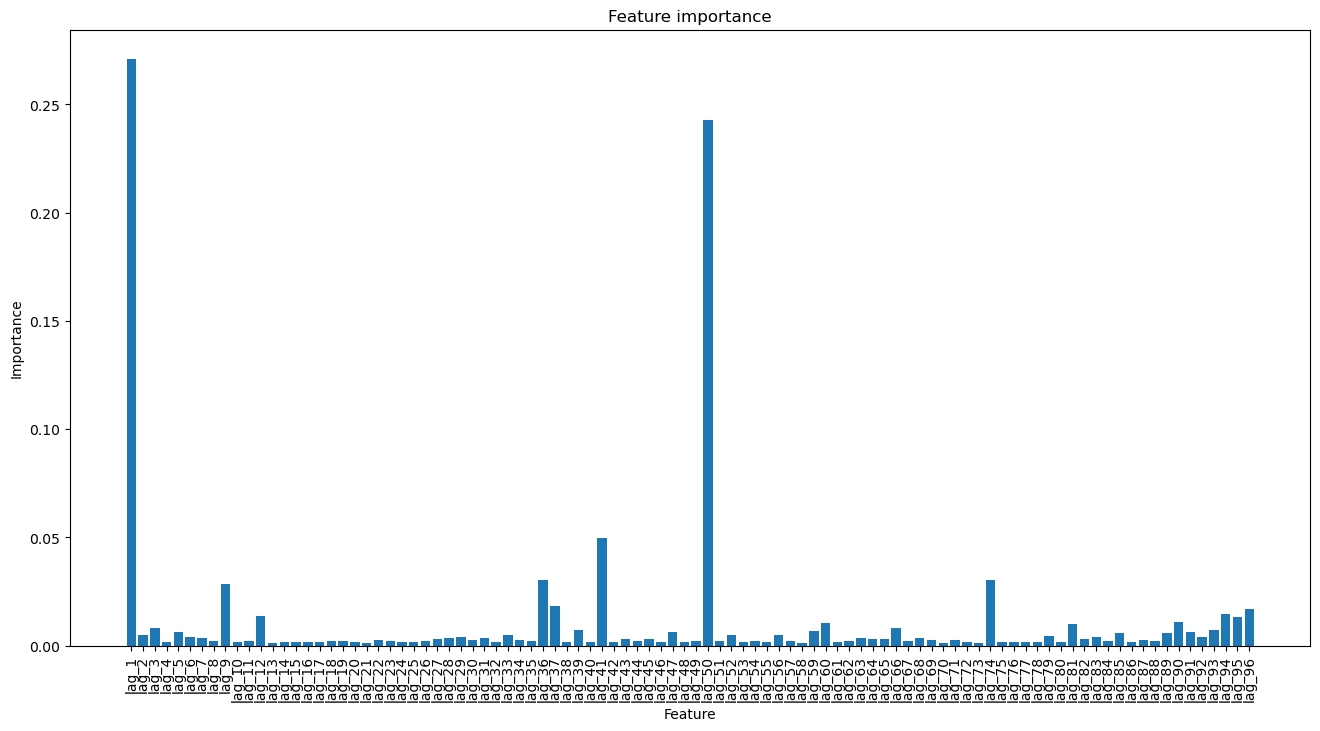

In [36]:
time_importance = model2.feature_importances_

plt.figure(figsize=(16, 8))
plt.bar(X2.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

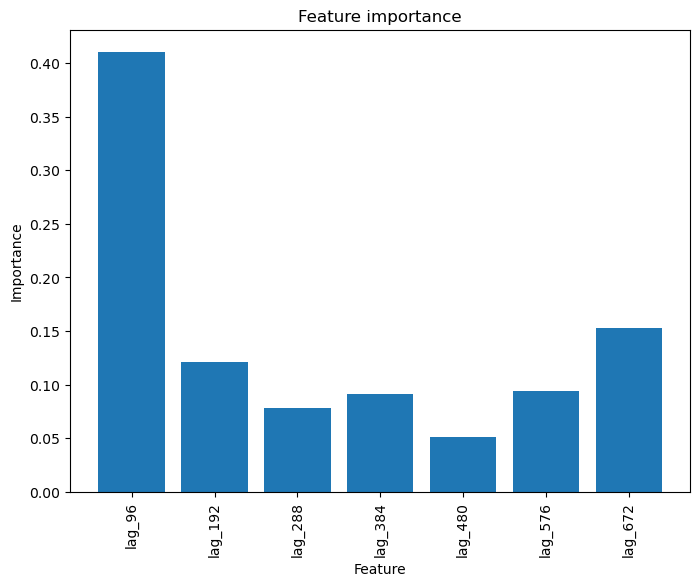

In [37]:
time_importance = model3.feature_importances_

plt.figure(figsize=(8, 6))
plt.bar(X3.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

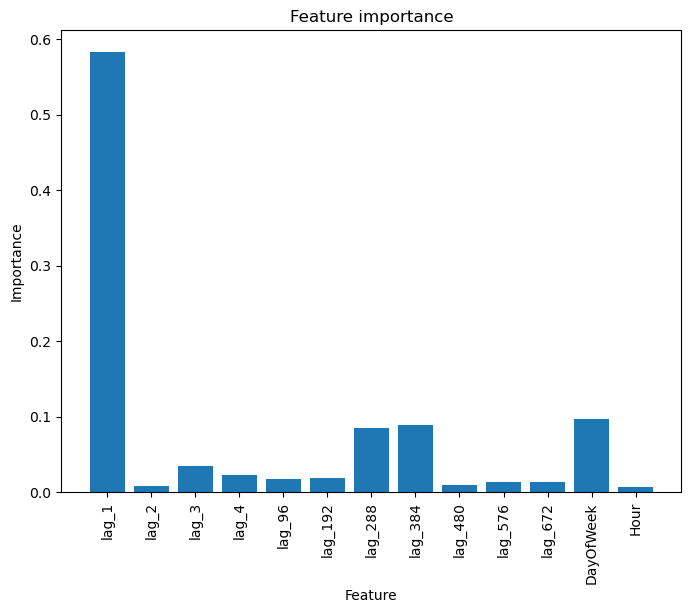

In [38]:
time_importance = model4.feature_importances_

plt.figure(figsize=(8, 6))
plt.bar(X4.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

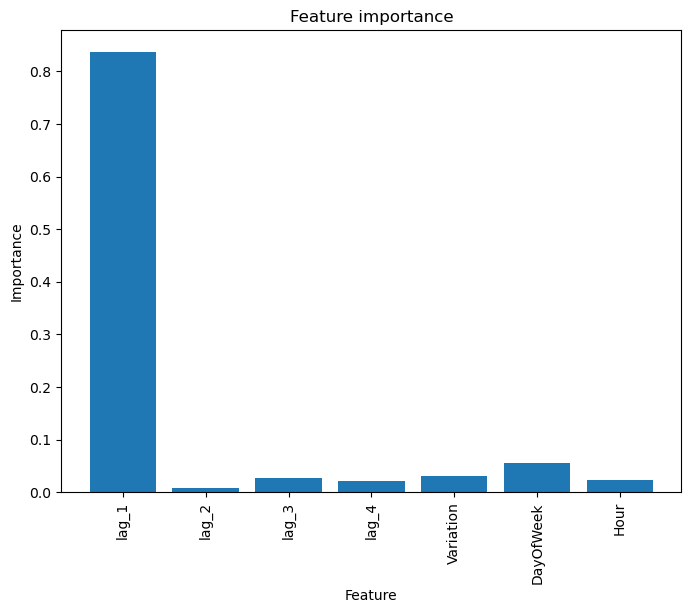

In [39]:
time_importance = model5.feature_importances_

plt.figure(figsize=(8, 6))
plt.bar(X5.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

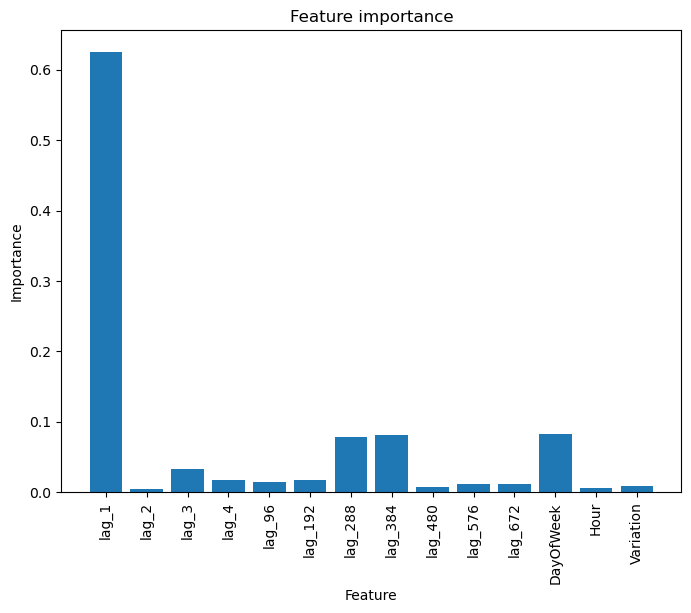

In [40]:
time_importance = model6.feature_importances_

plt.figure(figsize=(8, 6))
plt.bar(X6.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()